In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models,backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy


In [9]:
(x_train, y_train ), (x_valid, y_valid ) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0

x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_valid = np.reshape(x_valid, (-1 ,28, 28, 1))

In [77]:
type(x_train[0])

numpy.ndarray

In [35]:
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(28, 28, 1))
conv1 = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
conv2 = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
x = layers.Flatten()(conv2)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Latent space sampling
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │     50,192 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         51 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         51 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,110 (269.96 KB)

 Trainable params: 69,110 (269.96 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
outputs = layers.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3136)           │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Compute reconstruction loss without flattening
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    binary_crossentropy(data, reconstruction), axis=(1, 2) 
                )
            )
            reconstruction_loss *= 28 * 28
            
            # Compute KL divergence loss
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            kl_loss *= -0.5
        
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAEModel(encoder, decoder)
vae.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)
vae.summary()

vae.fit(
 x_train,
 epochs=64,
 batch_size=128,
 validation_data=(x_valid, x_valid)
)

Model: "vae_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 3), (None, 3), │        69,110 │
│                                 │ (None, 3)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        68,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,335 (536.46 KB)

 Trainable params: 137,335 (536.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - kl_loss: 82.0248 - loss: 159970.4688 - reconstruction_loss: 159888.4375 - val_loss: 0.0000e+00
Epoch 2/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 69.2457 - loss: 132420.4688 - reconstruction_loss: 132351.2188 - val_loss: 0.0000e+00
Epoch 3/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 53.1239 - loss: 121837.5859 - reconstruction_loss: 121784.4688 - val_loss: 0.0000e+00
Epoch 4/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 58.1244 - loss: 111763.0234 - reconstruction_loss: 111704.8984 - val_loss: 0.0000e+00
Epoch 5/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 55.0367 - loss: 108914.6875 - reconstruction_loss: 108859.6562 - val_loss: 0.0000e+00
Epoch 6/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 52.6559 - loss: 107256.8828 - reconstruction_loss: 107204.2266 - val_loss: 0.0000e+00
Epoch 7/64
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 50.9541 - loss: 106185.5078 -

In [17]:
from keras.src.saving import load_model

vae=load_model('vae.h5', custom_objects={'VAEModel': VAEModel} ,safe_mode=False)
vae.summary()

TypeError: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.VAEModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of VAEModel from its config.

Received config={'name': 'vae_model', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: VAEModel.__init__() missing 2 required positional arguments: 'encoder' and 'decoder'

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


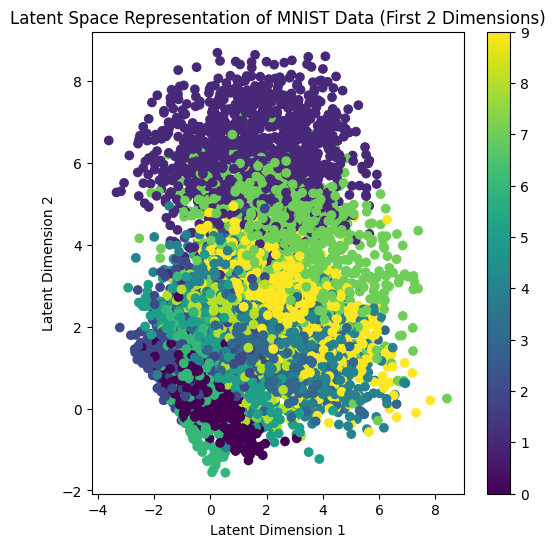

In [70]:
# Predict using the encoder to get the latent space representation
x_test_encoded = encoder.predict(x_valid, batch_size=128)[2]  

x_test_encoded_2d = x_test_encoded[:, :] 

# Plotting the 2D scatter plot of the latent space
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_2d[:, 2], x_test_encoded_2d[:, 1], c=y_valid, cmap='viridis')  # Use y_valid directly for coloring
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation of MNIST Data (First 2 Dimensions)')
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


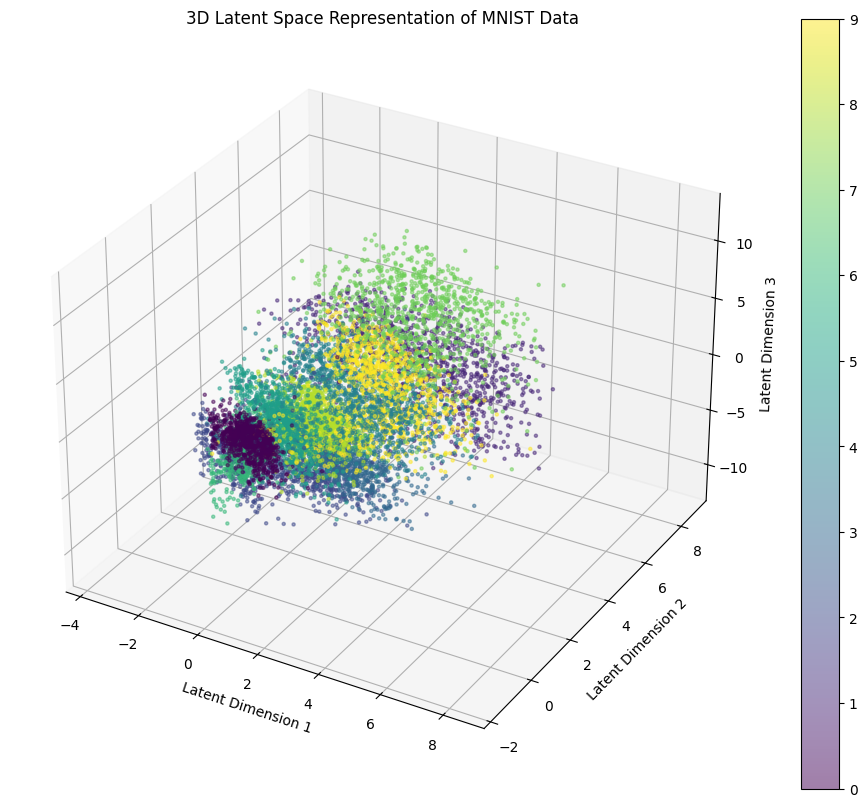

In [80]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import matplotlib.pyplot as plt
import numpy as np

# Encode the entire test dataset
x_test_encoded_3d = encoder.predict(x_valid, batch_size=128)[2]

x_test_encoded_3d = np.array(x_test_encoded_3d)

if y_valid.ndim > 1:
    y_valid_labels = np.argmax(y_valid, axis=1)
else:
    y_valid_labels = y_valid

# Plotting the 3D scatter plot of the latent space
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three dimensions of the latent space
scatter = ax.scatter(
    
    x_test_encoded_3d[:, 2],
    x_test_encoded_3d[:, 1],
    
    x_test_encoded_3d[:, 0], 
     
    c=y_valid,
    cmap='viridis',
    alpha=0.5,  # Transparency for better visualization
    s=5  # Size of the points
)

# Adding labels and a color bar
plt.colorbar(scatter)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('3D Latent Space Representation of MNIST Data')

plt.savefig('Images/3d_latent_space_MNIST.png', dpi=300, bbox_inches='tight')
plt.show()


In [74]:
vae.save('vae.h5')
vae.save('vae.keras')
vae.save_weights('mnist.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

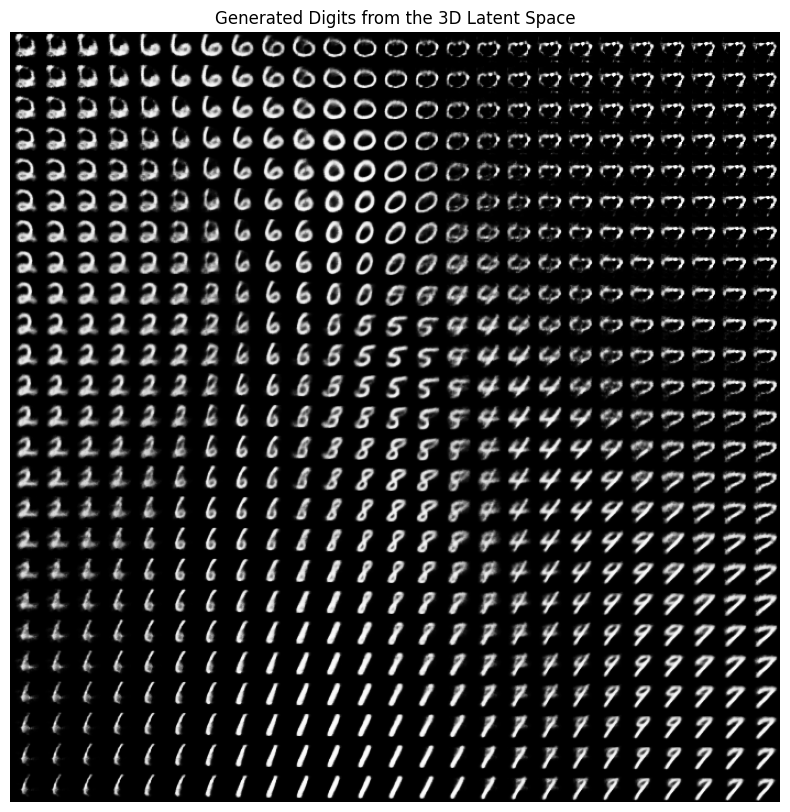

In [71]:
n = 25  # Number of images per dimension
digit_size = 28  # MNIST digit size (28x28 pixels)
figure = np.zeros((digit_size * n, digit_size * n))  # Initialize a large empty canvas
-
# Linearly spaced coordinates for creating the grid
grid_x = np.linspace(-6, 6, n)
grid_y = np.linspace(-1, 5, n)

# Iterate over the grid to fill in digits generated from the latent space
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Create a 3D latent space sample with the first two dimensions varying, and the third dimension fixed
        z_sample = np.array([[xi, yi,0]])  # Here, we set the third dimension to 0.0
        x_decoded = decoder.predict(z_sample)  # Decode the latent space sample into an image
        digit = x_decoded[0].reshape(digit_size, digit_size)  # Reshape the output to 28x28
        
        # Place the generated digit in the right location of the large canvas
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the manifold of generated digits
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title('Generated Digits from the 3D Latent Space')
plt.axis('off')
plt.show()


In [79]:
from PIL import Image

data=Image.fromarray(np.uint8(figure*255))
data.convert('L')

data.save('Images/generated_MNIST.png')